# Lab4: Statistical Learning in python

Outline:
1. Data Pre-procesing
2. statsmodels and sklearn

# Problem Statement

Estimate the **probability of Stephen Curry scoring a triple shot** in any given game as a function of other predictors such as period and position.


# 1. Loading data

In [132]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
import pandas as pd

def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    
    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""
    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(DataFrame(d, columns=h))

In [17]:
params = {'PlayerID':'201939',
          'PlayerPosition':'',
          'Season':'2016-17',
          'ContextMeasure':'FGA',
          'DateFrom':'',
          'DateTo':'',
          'GameID':'',
          'GameSegment':'',
          'LastNGames':'0',
          'LeagueID':'00',
          'Location':'',
          'Month':'0',
          'OpponentTeamID':'0',
          'Outcome':'',
          'Period':'0',
          'Position':'',
          'RookieYear':'',
          'SeasonSegment':'',
          'SeasonType':'Regular Season',
          'TeamID':'0',
          'VsConference':'',
          'VsDivision':''}

shotdata = get_nba_data('shotchartdetail', params)
shotdata.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021600003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,2,...,Right Side Center(RC),24+ ft.,28,130,257,1,0,20161025,GSW,SAS
1,Shot Chart Detail,0021600003,28,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,6,...,Right Side Center(RC),24+ ft.,25,189,174,1,1,20161025,GSW,SAS
2,Shot Chart Detail,0021600003,88,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,23,...,Right Side Center(RC),24+ ft.,27,159,229,1,0,20161025,GSW,SAS
3,Shot Chart Detail,0021600003,91,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,1,...,Right Side Center(RC),16-24 ft.,21,163,141,1,0,20161025,GSW,SAS
4,Shot Chart Detail,0021600003,184,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,47,...,Center(C),24+ ft.,26,-9,267,1,1,20161025,GSW,SAS


# 2. Data Pre-processing

Our task is first to obtain the total number of attempted and scored shots in any given game.

In [21]:
# See dtype of each column
shotdata.dtypes

GRID_TYPE              object
GAME_ID                object
GAME_EVENT_ID           int64
PLAYER_ID               int64
PLAYER_NAME            object
TEAM_ID                 int64
TEAM_NAME              object
PERIOD                  int64
MINUTES_REMAINING       int64
SECONDS_REMAINING       int64
EVENT_TYPE             object
ACTION_TYPE            object
SHOT_TYPE              object
SHOT_ZONE_BASIC        object
SHOT_ZONE_AREA         object
SHOT_ZONE_RANGE        object
SHOT_DISTANCE           int64
LOC_X                   int64
LOC_Y                   int64
SHOT_ATTEMPTED_FLAG     int64
SHOT_MADE_FLAG          int64
GAME_DATE              object
HTM                    object
VTM                    object
dtype: object

In [29]:
# Unique values of column of interest
shotdata["EVENT_TYPE"].unique()

array(['Missed Shot', 'Made Shot'], dtype=object)

In [48]:
shotdata["SHOT_ZONE_AREA"].unique()

array(['Right Side Center(RC)', 'Center(C)', 'Left Side Center(LC)',
       'Right Side(R)', 'Left Side(L)', 'Back Court(BC)'], dtype=object)

In [46]:
shotdata["SHOT_TYPE"].unique()

array(['3PT Field Goal', '2PT Field Goal'], dtype=object)

In [50]:
shotdata["SHOT_ZONE_RANGE"].unique()

array(['24+ ft.', '16-24 ft.', 'Less Than 8 ft.', '8-16 ft.',
       'Back Court Shot'], dtype=object)

In [33]:
shotdata["GAME_DATE"].unique()

array(['20161025', '20161028', '20161030', '20161101', '20161103',
       '20161104', '20161107', '20161109', '20161110', '20161113',
       '20161116', '20161118', '20161119', '20161121', '20161123',
       '20161125', '20161126', '20161128', '20161201', '20161203',
       '20161205', '20161207', '20161208', '20161210', '20161211',
       '20161213', '20161215', '20161217', '20161220', '20161222',
       '20161223', '20161225', '20161228', '20161230', '20170102',
       '20170104', '20170106', '20170108', '20170110', '20170112',
       '20170116', '20170118', '20170120', '20170122', '20170123',
       '20170125', '20170128', '20170201', '20170202', '20170204',
       '20170208', '20170210', '20170211', '20170213', '20170215',
       '20170223', '20170225', '20170227', '20170228', '20170302',
       '20170305', '20170306', '20170308', '20170310', '20170314',
       '20170316', '20170318', '20170320', '20170321', '20170324',
       '20170326', '20170328', '20170329', '20170331', '201704

In [34]:
shotdata["SHOT_ATTEMPTED_FLAG"].unique()

array([1])

In [35]:
shotdata["SHOT_MADE_FLAG"].unique()

array([0, 1])

In [157]:
train_data = shotdata.query('SHOT_TYPE=="3PT Field Goal"') # Only 3 pointers made
train_data

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021600003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,2,...,Right Side Center(RC),24+ ft.,28,130,257,1,0,20161025,GSW,SAS
1,Shot Chart Detail,0021600003,28,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,6,...,Right Side Center(RC),24+ ft.,25,189,174,1,1,20161025,GSW,SAS
2,Shot Chart Detail,0021600003,88,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,23,...,Right Side Center(RC),24+ ft.,27,159,229,1,0,20161025,GSW,SAS
4,Shot Chart Detail,0021600003,184,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,47,...,Center(C),24+ ft.,26,-9,267,1,1,20161025,GSW,SAS
7,Shot Chart Detail,0021600003,223,201939,Stephen Curry,1610612744,Golden State Warriors,2,3,17,...,Right Side Center(RC),24+ ft.,27,114,247,1,1,20161025,GSW,SAS
8,Shot Chart Detail,0021600003,227,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,55,...,Right Side Center(RC),24+ ft.,28,130,252,1,0,20161025,GSW,SAS
9,Shot Chart Detail,0021600003,289,201939,Stephen Curry,1610612744,Golden State Warriors,3,8,36,...,Left Side Center(LC),24+ ft.,31,-169,262,1,0,20161025,GSW,SAS
10,Shot Chart Detail,0021600003,324,201939,Stephen Curry,1610612744,Golden State Warriors,3,5,8,...,Center(C),24+ ft.,29,-73,288,1,0,20161025,GSW,SAS
12,Shot Chart Detail,0021600003,343,201939,Stephen Curry,1610612744,Golden State Warriors,3,4,6,...,Right Side(R),24+ ft.,22,225,36,1,0,20161025,GSW,SAS
17,Shot Chart Detail,0021600003,474,201939,Stephen Curry,1610612744,Golden State Warriors,4,6,11,...,Left Side(L),24+ ft.,23,-232,26,1,0,20161025,GSW,SAS


# 3. Logistic regression

We assume that the total number of scored shots are the realized value of a Binomial experiment where:


- no. of trials: the total number of triple shots attempted.

- no. of successes: total number of triple shots scored.

- $p_{i}$ is the probability of scoring a triple in any given game (which is our parameter of interest).


## 3.1 `statsmodels` package

In [162]:
# Fitting models using R-style formulas:
# See: http://www.statsmodels.org/dev/example_formulas.html
fitted_model1 = smf.glm(formula = 'SHOT_MADE_FLAG ~ LOC_X + LOC_Y + C(PERIOD) + C(SHOT_ZONE_AREA)',
                       data=train_data, 
                       family=sm.families.Binomial()).fit()

In [163]:
# See results
print(fitted_model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         SHOT_MADE_FLAG   No. Observations:                  788
Model:                            GLM   Df Residuals:                      776
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -519.22
Date:                Fri, 27 Apr 2018   Deviance:                       1038.4
Time:                        07:48:18   Pearson chi2:                     787.
No. Iterations:                     6                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -2.0036      1.485   

## 3.2 `scilearn` package

In [174]:
from patsy import dmatrices
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### 3.2.1 Prepare data for logistic regression

In [165]:
# create dataframes with an intercept column and dummy variables 
y, X = dmatrices('SHOT_MADE_FLAG ~ LOC_X + LOC_Y + C(PERIOD) + C(SHOT_ZONE_AREA)',
                  train_data, return_type="dataframe")

In [168]:
# flatten y into a 1-D array
y = np.ravel(y)

### 3.2.2 Train and test data 

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 3.3.3 Model fitting

In [175]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 3.3.4 Predicting the test set results and calculating the accuracy

In [176]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


### 3.3.5 Cross Validation

Cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 10-fold Cross-Validation to train our Logistic Regression model.

In [177]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.555


### 3.3.6 Confusion Matrix

In [178]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[124  21]
 [ 65  27]]


### 3.3.7 Compute precision, recall, F-measure and support

To quote from Scikit Learn:

- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

- The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

- The support is the number of occurrences of each class in y_test.


In [179]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.66      0.86      0.74       145
        1.0       0.56      0.29      0.39        92

avg / total       0.62      0.64      0.60       237



### 3.3.8 ROC curve

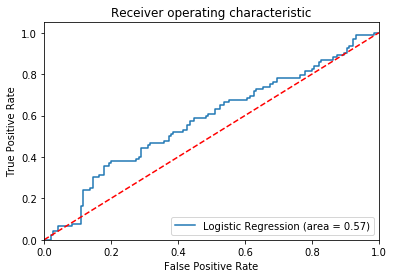

In [180]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# 4. Conclusions

In [189]:
Pr_pred = logreg.predict_proba(X_test)
Pr_pred = Pr_pred[:,[1]] # Probability of 